# Árboles de clasificación 

En **clasificación con árboles de decisión (`DecisionTreeClassifier`)**, el algoritmo selecciona **splits** (puntos de corte) para **maximizar la pureza de las clases** en cada nodo. En lugar de reducir la varianza (como en regresión), en clasificación se usa una **función de impureza**, como **Gini** o **Entropía**.

---

## ¿Cómo elige los splits el árbol en clasificación?
El algoritmo recorre **todas las características** y **todos los posibles umbrales** de división. Luego, selecciona **el umbral que cause la mayor reducción de impureza**.

### **Proceso paso a paso**:

1. **Para cada característica $j$ **:
   - Ordena los valores de $j$ de menor a mayor.
   - Prueba todas las divisiones posibles en los puntos medios entre valores consecutivos.

2. **Para cada posible umbral de división** $t$, divide los datos en dos grupos:
   - **Grupo Izquierdo:** $x_j \leq t$
   - **Grupo Derecho:** $x_j > t$

3. **Calcula la reducción de impureza** usando una de estas métricas:
   - **Índice Gini**:
     $$
     Gini = 1 - \sum p_i^2
     $$
   - **Entropía**:
     $$
     Entropía = -\sum p_i \log_2 p_i
     $$

4. **Elige el umbral $t$ que maximiza la reducción de impureza**:

$$
\text{Ganancia de Impureza} = \text{Impureza Nodo Padre} - \left( \frac{N_1}{N} \times \text{Impureza}(G1) + \frac{N_2}{N} \times \text{Impureza}(G2) \right)
$$

5. **Repite este proceso recursivamente** en cada nuevo nodo hasta cumplir una condición de parada (profundidad máxima, mínimo de muestras, etc.).

---

## **Ejemplo de cálculo con Índice Gini**
Supongamos que tenemos una variable `color` con dos clases: **Rojo (R)** y **Azul (A)**.

Antes de dividir los datos:

Dataset original: [R, R, A, A, A, R, A]


- Probabilidades: $P(R) = \frac{3}{7}, P(A) = \frac{4}{7}$
- **Índice Gini antes de dividir**:
  $$
  Gini = 1 - (P(R)^2 + P(A)^2) = 1 - \left(\left(\frac{3}{7}\right)^2 + \left(\frac{4}{7}\right)^2\right) = 0.49
  $$


- **Reducción de Gini**:
  $$
  0.49 - \left( \frac{3}{7} \times 0 + \frac{4}{7} \times 0 \right) = 0.49
  $$
✅ ¡Este es un split perfecto! Porque cada grupo quedó completamente puro.

---

## 🔹 **Ejemplo gráfico**
Si tenemos una variable `altura` y queremos clasificar entre **gato 🐱** y **perro 🐶**, el algoritmo probaría distintos valores de `altura` como puntos de corte.

| Split en `altura` | Reducción de Impureza |
|-------------------|----------------------|
| **20 cm**        | 0.30                 |
| **35 cm**        | 0.50 ✅ **Mejor** |
| **50 cm**        | 0.45                 |

El **split óptimo** es en `altura = 35 cm`, porque **maximiza la reducción de impureza**.

---

## 🔹 ¿Qué pasa si hay múltiples características?
Cuando hay más de una variable predictora, el algoritmo:
1. **Prueba cada característica** y encuentra su mejor split.
2. **Elige la característica con la mayor reducción de impureza**.
3. **Divide los datos y repite el proceso recursivamente**.

---

## **Diferencias entre Clasificación y Regresión**
| **Aspecto**       | **Clasificación (`DecisionTreeClassifier`)** | **Regresión (`DecisionTreeRegressor`)** |
|-------------------|---------------------------------|------------------------------|
| **Criterio de división** | `Gini` o `Entropía` (pureza de clases) | Reducción de varianza |
| **Función de impureza** | $Gini = 1 - \sum p_i^2$ | $\frac{1}{n} \sum (y_i - \bar{y})^2$ |
| **Medida de importancia** | Cuánto reduce la impureza en cada nodo | Cuánto reduce la varianza en cada nodo |

---


### Ahora usando paquete

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

df = pd.read_csv('titanic.csv')

df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df = pd.get_dummies(df)
del df['Sex_female']

# Variables predictoras y objetivo
X = df.drop('Survived', axis=1)
y = df['Survived']

# --- División en conjunto de entrenamiento y test (80%-20%) ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

# Entrenar el modelo de árbol de decisión
tree = DecisionTreeClassifier(max_depth=2).fit(X_train,y_train)

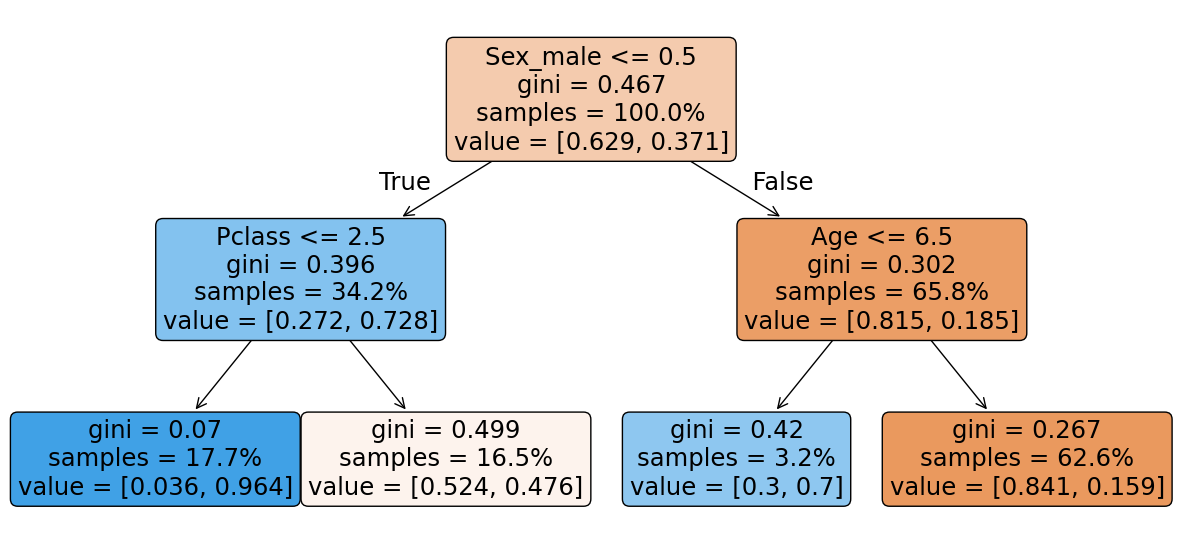

In [2]:
plt.figure(figsize=(15, 7))
plot_tree(tree, feature_names=list(X_train.columns), filled = True, rounded = True, proportion=True)
plt.show()

### Grid search 

In [21]:
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline

In [22]:
pipeline = Pipeline([
    ('tree', DecisionTreeClassifier())
])

params = {
    'tree__max_depth': [1,2,3,4,5,6,7,8,9,10,11,12]
}

grid_tree = GridSearchCV(estimator = pipeline, cv=5, n_jobs=-1, scoring = 'roc_auc', param_grid = params)
grid_tree.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                             12]},
             scoring='roc_auc')

In [23]:
grid_tree.best_params_

{'tree__max_depth': 3}

In [24]:
best_model = grid_tree.best_estimator_.named_steps['tree']

In [25]:
# Calcula el AUC score

predicciones = best_model.predict_proba(X_test)[:,1]
roc_auc_score(y_score=predicciones, y_true=y_test)

0.820307568715212

### Importancia de variables

In [26]:
importancias = pd.DataFrame({
    'variables': X_train.keys(),
    'importancia': best_model.feature_importances_
})

importancias

,variables,importancia
0,Pclass,0.182446
1,Age,0.086542
2,SibSp,0.048164
3,Parch,0.000000
4,Fare,0.088806
5,Sex_male,0.594041
6,Embarked_C,0.000000
7,Embarked_Q,0.000000
8,Embarked_S,0.000000
